In [2]:
import re
import numpy as np
from tqdm import tqdm
import pandas as pd
from sqlalchemy import create_engine
import pickle 
from politenessr import Politenessr
from transformers import XLMRobertaTokenizer
from thefuzz import fuzz
import matplotlib.pyplot as plt
import seaborn as sns

tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-base')

/home/shreyah/.conda/envs/politeness/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/shreyah/.conda/envs/politeness/lib/python3.8/site-packages/thefuzz/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [3]:
def read_pickle(file_path):
    with open(file_path, 'rb') as file:
        pickle_file = pickle.load(file)
    return pickle_file

en_dialog = read_pickle("dialog_act_data/english_dialog_acts_updated.p")
es_dialog = read_pickle("dialog_act_data/spanish_dialog_acts_updated.p")
ja_dialog = read_pickle("dialog_act_data/japanese_dialog_acts_updated.p")
zh_dialog = read_pickle("dialog_act_data/chinese_dialog_acts_updated.p")

en_shap = read_pickle("../shapley/xlm_shap_values/english.p")
es_shap = read_pickle("../shapley/xlm_shap_values/spanish.p")
ja_shap = read_pickle("../shapley/xlm_shap_values/japanese.p")
zh_shap = read_pickle("../shapley/xlm_shap_values/chinese.p")

In [4]:
def get_num_sentences(df):
    total_len = 0
    for u in df["Translated Sentences"]:
        total_len += len(u)
    return total_len

print("num_sent_en = ", get_num_sentences(en_dialog))
print("num_sent_es = ", get_num_sentences(es_dialog))
print("num_sent_ja = ", get_num_sentences(ja_dialog))
print("num_sent_zh = ", get_num_sentences(zh_dialog))

num_sent_en =  15624
num_sent_es =  14952
num_sent_ja =  13057
num_sent_zh =  13656


In [5]:
def get_token_level_shapley_values(shap_pickle, tokenizer):
    token_level_shapley_values = []
    utterances = []
    shap_data = shap_pickle.data
    shap_values = shap_pickle.values
    shap_base = shap_pickle.base_values
    for idx in tqdm(range(len(shap_data))):
        tokens = shap_data[idx]
        values = shap_values[idx]
        base = shap_base[idx]

        # divide base amongst all tokens
        base_add = base/len(tokens)
        values = [v + base_add for v in values]
        
        utterance_string = tokenizer.convert_tokens_to_string(tokens)
        utterances.append(utterance_string)
        token_level_shapley_values.append([tokens, values, base])
    return utterances, token_level_shapley_values

def process_tokens(token_list):
    #remove all spaces and punctuation from token that are added by tokenizer
    to_replace = [" ", "_", "▁", ".", ",", "\n", ")", "(", "[", "]"]
    for r in to_replace:
        token_list = [x.replace(r, "") for x in token_list]
    #make all lowercase
    token_list = [str(x).lower().strip() for x in token_list]
    #remove all empty strings
    return token_list

def get_start_end_idxs(shap_tokens, match_tokens, fuzz_threshold):
    start_idx = -1
    end_idx = -1

    max_fuzz = fuzz_threshold

    processed_shap_tokens = process_tokens(shap_tokens)
    processed_match_tokens = process_tokens(match_tokens)

    match_sent = tokenizer.convert_tokens_to_string(match_tokens)

    for j in range(len(processed_shap_tokens)):
        if(processed_shap_tokens[j] == processed_match_tokens[0]):
            sent_1 = tokenizer.convert_tokens_to_string(shap_tokens[j:j+len(match_tokens)])
            sent_2 = tokenizer.convert_tokens_to_string(shap_tokens[j:min(j+len(match_tokens)+1, len(shap_tokens))])
            sent_3 = tokenizer.convert_tokens_to_string(shap_tokens[j:min(j+len(match_tokens)+2, len(shap_tokens))])
            fuzz1 = fuzz.ratio(sent_1, match_sent)
            fuzz2 = fuzz.ratio(sent_2, match_sent)
            fuzz3 = fuzz.ratio(sent_3, match_sent)
            if(fuzz1 > max_fuzz):
                start_idx = j
                end_idx = j+len(match_tokens)
                max_fuzz = fuzz1
            if(fuzz2 > max_fuzz):
                start_idx = j
                end_idx = j+len(match_tokens)+1
                max_fuzz = fuzz2
            if(fuzz3 > max_fuzz):
                start_idx = j
                end_idx = j+len(match_tokens)+2
                max_fuzz = fuzz3
    return start_idx, end_idx

def string_to_list(string):
    string = string.replace("[", "")
    string = string.replace("]", "")
    list_items = string.split("\",")
    final_items = []
    for item in list_items:
        split_items = item.split("\',")
        for i in range(len(split_items)):
            final_items.append(split_items[i])
    for i in range(len(final_items)):
        final_items[i] = final_items[i].strip()
        final_items[i] = final_items[i][1:]
    return final_items

def process_dialog_acts(dialog_labels):
    for i in range(len(dialog_labels)):
        dialog_labels[i] = str(dialog_labels[i])
        dialog_labels[i] = dialog_labels[i].replace("[", "")
        dialog_labels[i] = dialog_labels[i].replace("]", "")
        dialog_labels[i] = dialog_labels[i].replace("'", "")
        dialog_labels[i] = dialog_labels[i].replace(",", "")
        dialog_labels[i] = dialog_labels[i].replace("(", "")
        dialog_labels[i] = dialog_labels[i].replace(")", "")
        dialog_labels[i] = dialog_labels[i].strip()
    return dialog_labels


def get_sentence_shapley(shapley_values, dialog_acts, fuzz_threshold=70, return_sentences=False):
    _, shap_object = get_token_level_shapley_values(shapley_values, tokenizer)
    no_match_count = 0
    shap_sentence_vals = []
    dialog_sentence_labels = []
    raw_sentences = []
    assert(len(shapley_values) == len(dialog_acts))
    for i in range(len(shapley_values)):
        sentences = dialog_acts["Sentences"][i]
        split_sentences = string_to_list(sentences)
        
        dialog_labels = dialog_acts["Dialog Acts"][i]
        dialog_labels = process_dialog_acts(dialog_labels)
        try:
            assert(len(split_sentences) == len(dialog_labels))
        except(AssertionError):
            continue
        
        local_sentence_vals = []
        shap_tokens = shap_object[i][0]
        for sent in split_sentences:
            match_tokens = tokenizer.tokenize(sent)
            start_idx, end_idx = get_start_end_idxs(shap_tokens, match_tokens, fuzz_threshold)
            if(start_idx == -1 or end_idx == -1):
                start_idx, end_idx = get_start_end_idxs(shap_tokens, match_tokens[1:], fuzz_threshold)
            if(start_idx == -1 or end_idx == -1):
                start_idx, end_idx = get_start_end_idxs(shap_tokens, match_tokens[2:], fuzz_threshold)
            if(start_idx == -1 or end_idx == -1):
                no_match_count += 1
            total_value = np.sum(shap_object[i][1][start_idx:end_idx])
            local_sentence_vals.append(total_value)
        shap_sentence_vals.append(local_sentence_vals)
        dialog_sentence_labels.append(dialog_labels)
        raw_sentences.append(split_sentences)

    print("No match count: %d" % no_match_count)
    if(return_sentences):
        return shap_sentence_vals, dialog_sentence_labels, raw_sentences
    return shap_sentence_vals, dialog_sentence_labels


In [6]:
shap_sent_en, dialog_labels_en = get_sentence_shapley(en_shap, en_dialog, 80)
shap_sent_es, dialog_labels_es = get_sentence_shapley(es_shap, es_dialog, 80)
shap_sent_ja, dialog_labels_ja = get_sentence_shapley(ja_shap, ja_dialog, 60)
shap_sent_zh, dialog_labels_zh = get_sentence_shapley(zh_shap, zh_dialog, 60)

100%|██████████| 5700/5700 [00:00<00:00, 9081.01it/s]


No match count: 4


100%|██████████| 5699/5699 [00:00<00:00, 9286.78it/s]


No match count: 6


100%|██████████| 5699/5699 [00:00<00:00, 12826.31it/s]


No match count: 4


100%|██████████| 5700/5700 [00:00<00:00, 7543.40it/s] 


No match count: 6


In [7]:
dialog_act_labels = {
    "s": "Statement",
    "sd": "Declarative Statement",
    "sv": "Opinion Statement",
    "oo": "Open-option",
    "qy": "Yes/No Question",
    "qw": "\"Wh-\" Question",
    "qo": "Open Question",
    "qr": "Or-Question",
    "qrr": "Or-Clause",
    "qh": "Rhetorical Question",
    "^d": "Declarative Question",
    "qy^d": "Declarative Yes/No Question",
    "^g": "Tag Question",
    "ad": "Directive Action",
    "co": "Offer",
    "cc": "Commit",
    "fp": "Conventional Opening",
    "fc": "Conventional Closing",
    "fx": "Explicit-performative",
    "fe": "Exclamation",
    "fo": "Other-forward-function",
    "ft": "Forward-Function: Thanking",
    "fw": "Forward-Function: You're-Welcome",
    "fa": "Forward-Function: Apology",
    "aa": "Acceptance",
    "aap": "Accept-part",
    "am": "Maybe",
    "arp": "Reject-part",
    "ar": "Reject",
    "^h": "Hold before answer/agreement",
    "br": "Signal-non-understanding",
    "br^m": "Signal-non-understanding",
    "b": "Acknowledge",
    "bh": "Acknowledge",
    "bk": "Acknowledge-answer",
    "^m": "Repeat-phrase",
    "^2": "Completion",
    "bf": "Summarize/Reformulate",
    "ba": "Appreciation",
    "by": "Sympathy",
    "bd": "Downplayer",
    "bc": "Correct-misspeaking",
    "ny":  "Yes answers",
    "nn":  "No answers",
    "na":  "Affirmative non-yes answers",
    "nd":  "Dispreferred answers",
    "ng":  "Negative non-No Answer",
    "no":  "Other answers",
    "sd^e": "Statement expanding y/n answer",
    "sv^e": "Statement expanding y/n answer",
    "^e":  "Expansions of y/n answers",
    "nn^e": "No plus expansion",
    "ny^e": "Yes plus expansion",
    "^q":  "Quoted material",
}

def relabel_dict(dictionary):
    #rename keys to be more readable
    new_dict = {}
    for key in dictionary.keys():     
        if(key == "Summarize/Reformulate"): key_new = "Summarize/\nReformulate"
        elif(key == "Declarative Yes/No Question"): key_new = "Declarative\nYes/No Question"
        else: key_new = key.replace(" ", "\n") 
        new_dict[key_new] = dictionary[key]
    return new_dict

def get_dialog_mapping(shap_sent, dialog_labels):
    assert(len(shap_sent) == len(dialog_labels))
    shap_dialog_mapping = {}
    shap_sent_flatten = np.concatenate(shap_sent)
    dialog_labels_flatten = np.concatenate(dialog_labels)
    for i in range(len(shap_sent_flatten)):
        dialog_acts_split = dialog_labels_flatten[i].split(" ")
        for split_act in dialog_acts_split:
            split_act = split_act.strip()
            try:
                shap_dialog_mapping[split_act].append(shap_sent_flatten[i])
            except(KeyError):
                shap_dialog_mapping[split_act] = [shap_sent_flatten[i]]
    return shap_dialog_mapping

def average_shap_vals(mapping):
    mapping_aggregated = {}
    mapping_counts = {}
    for category in mapping:
        if(len(mapping[category]) < 1):
            continue
        mapping_aggregated[category] = np.mean(mapping[category])
        mapping_counts[category] = len(mapping[category])
    return mapping_aggregated, mapping_counts

mapping_en = get_dialog_mapping(shap_sent_en, dialog_labels_en)
mapping_es = get_dialog_mapping(shap_sent_es, dialog_labels_es)
mapping_ja = get_dialog_mapping(shap_sent_ja, dialog_labels_ja)
mapping_zh = get_dialog_mapping(shap_sent_zh, dialog_labels_zh)

en_avg_raw, en_counts_raw = average_shap_vals(mapping_en)
es_avg_raw, es_counts_raw = average_shap_vals(mapping_es)
ja_avg_raw, ja_counts_raw = average_shap_vals(mapping_ja)
zh_avg_raw, zh_counts_raw = average_shap_vals(mapping_zh)

THRESH = 20
#get all dialog acts that have count > THRESH in all languages
all_dialog_acts = []
for category in en_counts_raw:
    if(category in es_counts_raw and category in ja_counts_raw and category in zh_counts_raw):
        if(category not in dialog_act_labels): continue
        if(en_counts_raw[category] > THRESH and es_counts_raw[category] > THRESH and ja_counts_raw[category] > THRESH and zh_counts_raw[category] > THRESH):
            all_dialog_acts.append(category)

#trim avg and count dicts to only include dialog acts that have count > THRESH in all languages
en_avg = {dialog_act_labels[k]: v for k, v in en_avg_raw.items() if k in all_dialog_acts}
es_avg = {dialog_act_labels[k]: v for k, v in es_avg_raw.items() if k in all_dialog_acts}
ja_avg = {dialog_act_labels[k]: v for k, v in ja_avg_raw.items() if k in all_dialog_acts}
zh_avg = {dialog_act_labels[k]: v for k, v in zh_avg_raw.items() if k in all_dialog_acts}

en_counts = {dialog_act_labels[k]: v for k, v in en_counts_raw.items() if k in all_dialog_acts}
es_counts = {dialog_act_labels[k]: v for k, v in es_counts_raw.items() if k in all_dialog_acts}
ja_counts = {dialog_act_labels[k]: v for k, v in ja_counts_raw.items() if k in all_dialog_acts}
zh_counts = {dialog_act_labels[k]: v for k, v in zh_counts_raw.items() if k in all_dialog_acts}

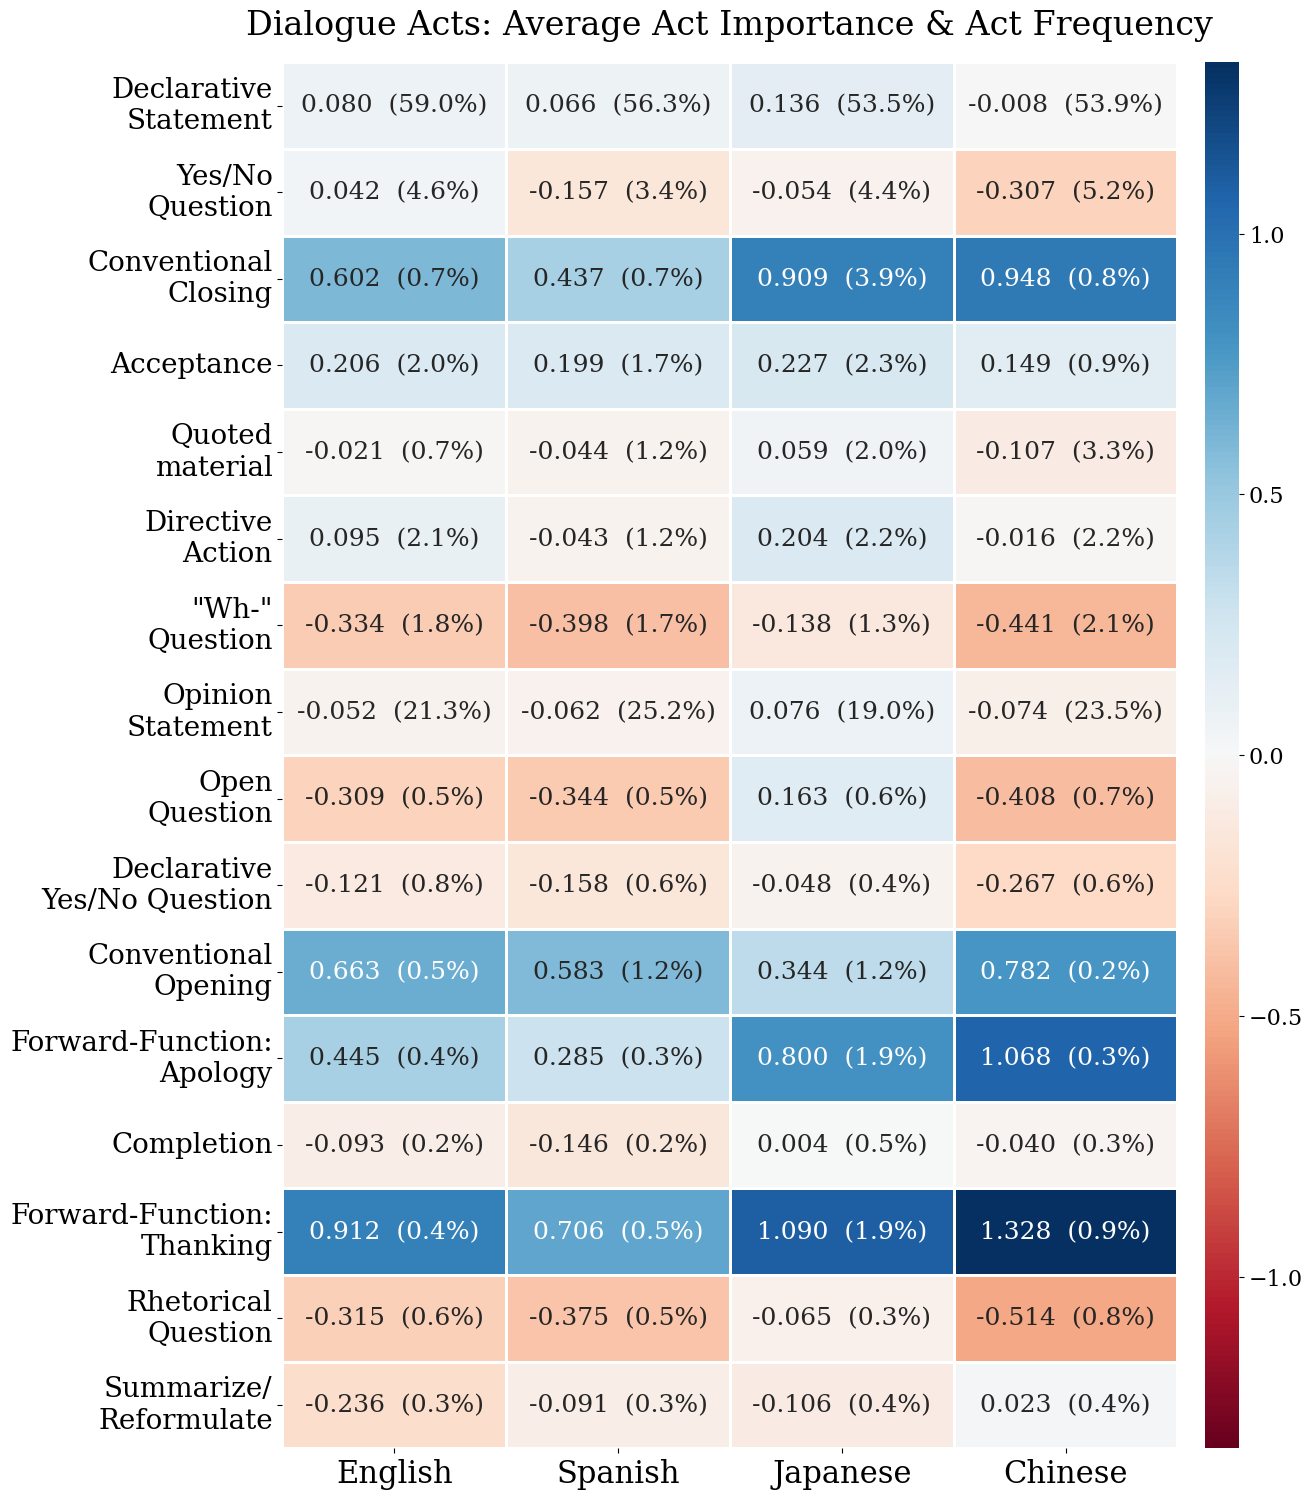

In [8]:
#make bar graphs for each dialog act category
num_sent_en =  15624
num_sent_es =  14952
num_sent_ja =  13057
num_sent_zh =  13656

value_to_label_map = {}
for key in en_avg.keys():
    to_iterate = [en_avg, es_avg, ja_avg, zh_avg]
    counts_to_iterate = [en_counts, es_counts, ja_counts, zh_counts]
    sen_length_to_iterate = [num_sent_en, num_sent_es, num_sent_ja, num_sent_zh]
    for idx, _ in enumerate(to_iterate):
        val = to_iterate[idx][key]
        count = counts_to_iterate[idx][key]
        num_sent = sen_length_to_iterate[idx]
        count_percent = count/num_sent * 100
        #format val to string with 3 sig figs
        val_string = "{:.3f}".format(val)
        count_string = "{:.1f}%".format(count_percent)
        label = val_string + "  (" + count_string + ")"
        value_to_label_map[val] = label

en_avg_relabeled = relabel_dict(en_avg)
es_avg_relabeled = relabel_dict(es_avg)
ja_avg_relabeled = relabel_dict(ja_avg)
zh_avg_relabeled = relabel_dict(zh_avg)

df = pd.DataFrame([en_avg_relabeled, es_avg_relabeled, ja_avg_relabeled, zh_avg_relabeled],
                   index=["English", "Spanish", "Japanese", "Chinese"])

labels = (df.T).applymap(lambda v: 'NA' if v == 0 else value_to_label_map[v])
plt.rcParams['font.family'] = 'serif'
plt.figure(figsize=(14, 18))
plt.title("Dialogue Acts: Average Act Importance & Act Frequency", fontsize=24, pad=20)
ax = sns.heatmap(df.T, annot=labels, 
                cmap="RdBu", 
                vmin=-np.max(df.max()) , 
                vmax=np.max(df.max()), 
                annot_kws={"size": 18, 'verticalalignment': 'center', 'horizontalalignment': 'left'}, 
                cbar_kws={'aspect': 40, 'pad': 0.025},
                linewidths=1, 
                fmt = '')
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=16)
plt.xticks(fontsize=22)
plt.yticks(fontsize=20)
plt.show()


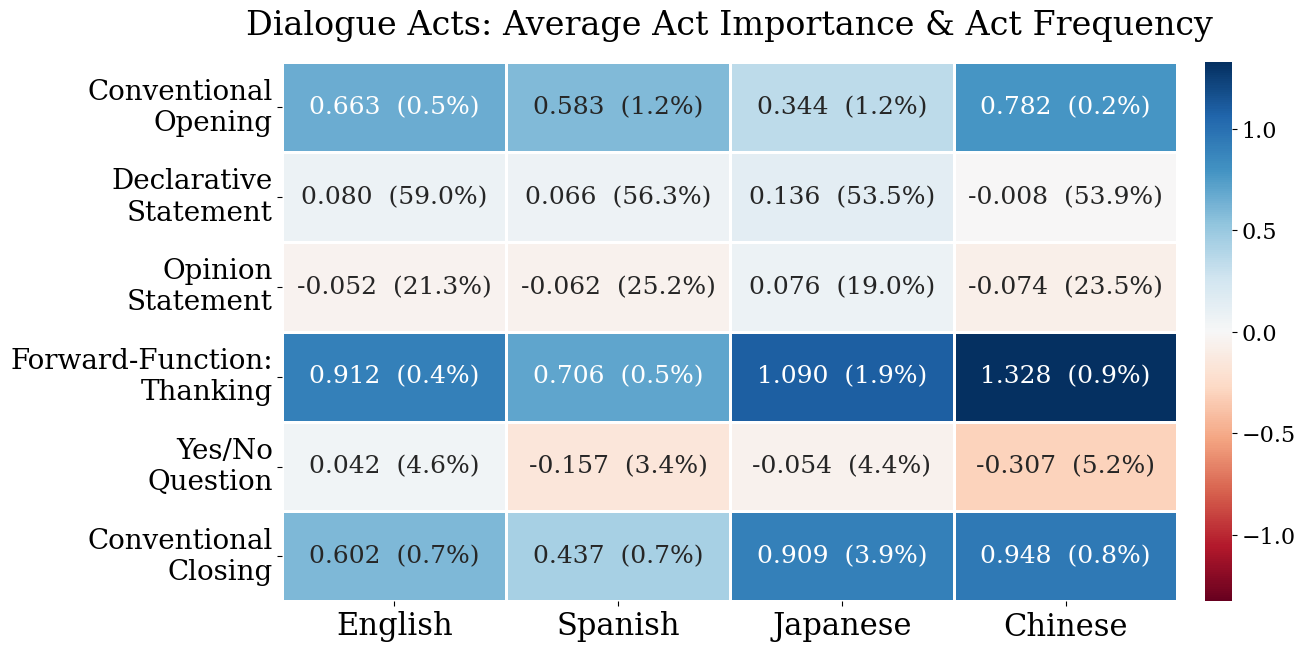

In [9]:
keys_to_keep = ["fp", "sd", "sv", "ft", "qy",  "fc"]

en_avg_trimmed = {dialog_act_labels[x]: en_avg_raw[x] for x in keys_to_keep}
es_avg_trimmed = {dialog_act_labels[x]: es_avg_raw[x] for x in keys_to_keep}
ja_avg_trimmed = {dialog_act_labels[x]: ja_avg_raw[x] for x in keys_to_keep}
zh_avg_trimmed = {dialog_act_labels[x]: zh_avg_raw[x] for x in keys_to_keep}

en_counts_trimmed = {dialog_act_labels[x]: en_counts_raw[x] for x in keys_to_keep}
es_counts_trimmed = {dialog_act_labels[x]: es_counts_raw[x] for x in keys_to_keep}
ja_counts_trimmed = {dialog_act_labels[x]: ja_counts_raw[x] for x in keys_to_keep}
zh_counts_trimmed = {dialog_act_labels[x]: zh_counts_raw[x] for x in keys_to_keep}

value_to_label_map = {}
for key in en_avg_trimmed.keys():
    to_iterate = [en_avg_trimmed, es_avg_trimmed, ja_avg_trimmed, zh_avg_trimmed]
    counts_to_iterate = [en_counts_trimmed, es_counts_trimmed, ja_counts_trimmed, zh_counts_trimmed]
    sen_length_to_iterate = [num_sent_en, num_sent_es, num_sent_ja, num_sent_zh]
    for idx, _ in enumerate(to_iterate):
        val = to_iterate[idx][key]
        count = counts_to_iterate[idx][key]
        num_sent = sen_length_to_iterate[idx]
        count_percent = count/num_sent * 100
        #format val to string with 3 sig figs
        val_string = "{:.3f}".format(val)
        count_string = "{:.1f}%".format(count_percent)
        label = val_string + "  (" + count_string + ")"
        value_to_label_map[val] = label

en_avg_trimmed = relabel_dict(en_avg_trimmed)
es_avg_trimmed = relabel_dict(es_avg_trimmed)
ja_avg_trimmed = relabel_dict(ja_avg_trimmed)
zh_avg_trimmed = relabel_dict(zh_avg_trimmed)

df = pd.DataFrame([en_avg_trimmed, es_avg_trimmed, ja_avg_trimmed, zh_avg_trimmed],
                     index=["English", "Spanish", "Japanese", "Chinese"])

labels = (df.T).applymap(lambda v: 'NA' if v == 0 else value_to_label_map[v])
plt.rcParams['font.family'] = 'serif'
plt.figure(figsize=(14, 7))
plt.title("Dialogue Acts: Average Act Importance & Act Frequency", fontsize=24, pad=20)
ax = sns.heatmap(df.T, annot=labels, 
                cmap="RdBu", 
                vmin=-np.max(df.max()) , 
                vmax=np.max(df.max()), 
                annot_kws={"size": 18, 'verticalalignment': 'center', 'horizontalalignment': 'left'}, 
                cbar_kws={'aspect': 20, 'pad': 0.025},
                linewidths=1, 
                fmt = '')
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=16)
plt.xticks(fontsize=22)
plt.yticks(fontsize=20)
plt.show()